# Assignment 5

## Problem 1: RNNs as a generative model

1. We will train an RNN (LSTM or GRU; you choose one) that can predict the rest of the bottom half of an MNIST image given the top half. So, yes, this is a generative model that can “draw” handwritten digits.

2. As the first step, let’s divide every training image into 16 smaller patches. Since the original images are with 28×28 pixels, what I mean is that you need to chop off the image into 7 × 7 patches. There is no overlap between those patches. Above is an example from my implementation. It’s an image of number “5” obviously, but it’s just chopped into 16 patches.

3. Let’s give them an order. Let’s do it from the top left corner to the bottom right corner. Below is going to be the order of the patches.

4. Now that we have an order, we’ll use it to turn each MNIST image into a sequence of smaller patches. Although, below would be a potential way to turn these patches into a sequence,I wouldn’t use this way exactly, because then it is a sequence of 2d arrays, not vectors.

5. While I’ll keep the same order, to simplify our model architecture, we will vectorize each patch from 7×7 to a 49-dimensional vector. Finally, our sequence is a matrix X ∈ R16×49, where 16 is the number of “time” steps. This is an input sequence to your RNN for training.

6. With a proper batch size, say 100, now an input tensor is defined as a 3D array of size 100 × 16 × 49. But, I’ll ignore the batch size in the equations below to keep the notation uncluttered.

7. Train an RNN out of these sequences. There must be 50,000 such sequences, or 500 minibatches if your batch size is 100. I tried a couple of different model architectures but both worked quite well. The smallest one I tried was a 2×64 LSTM. I didn’t do any fancy things like gradient clipping, as the longest sequence length is still just 16.

8. Remember to add a dense layer, so that you can convert whatever choice of the LSTM or GRU hidden dimension back to 49. You may also want to use an activation function for your output units so that the output is bounded.

9. You need to train your RNN in a way that it can predict the next patch out of the so-far-observed patches. To this end, the LSTM should predict the next patch in the following manner:
(Yt,:, Ct+1,:, Ht+1,:) = LSTM(Xt,:, Ct,:, Ht,:), (1)
where C and H denote the memory cell and hidden state, respectively (or with GRU C will be omitted), that are 0 when t = 0. To work as a predictive model, when you train, you need to compare Yt,: (the prediction) with Xt+1,: (the next patch) and compute the loss (I used MSE as I’m lazy).

10. In other words, you will feed the input sequence X1:15,: (the full sequence except for the last patch) to the model, whose output Y ∈ R15×49 will need to be compared to X2:16,:, vector-by-vector, to compute
the loss:

L = 􏰀 􏰀 D(Xt,d||Yt−1,d), (2)
t=2 d=1 where D(·||·) is a distance metric of your choice.

11. Let’s use the test set to validate the model at every epoch, to see if it overfits. If it starts to overfit, stop the training process early. It took from a few to tens of minutes to train the network.

In [30]:
import numpy as np
import tensorflow as tf
import numpy as np
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import History 
from tensorflow.keras.layers import Activation,Dense,LSTM,Input

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Download the data

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


### Preprocessing the data

In [ ]:
# Scaling
x_train = x_train/255
x_test = x_test/255


## training
x_train1 = x_train[0:50000]
arr = []
for j in range(x_train1.shape[0]):
  temp_arr = []
  for i in range(0,x_train1.shape[1],7):
    for m in range(0,x_train1.shape[2],7):
      flatten = x_train1[j][i:i+7,m:m+7].flatten()
      temp_arr.append(flatten)
  arr.append(temp_arr)

arr = np.array(arr)
train_arr = arr[:,0:15,:]
label_arr = arr[:,1:16,:]


# testing
test_arr = []
for j in range(x_test.shape[0]):
  temp_arr = []
  for i in range(0,x_test.shape[1],7):
    for m in range(0,x_test.shape[2],7):
      flatten = x_test[j][i:i+7,m:m+7].flatten()
      temp_arr.append(flatten)
  test_arr.append(temp_arr)

test_arr = np.array(test_arr)
test_arr_X = test_arr[:,0:15,:]
label_test_arr = test_arr[:,1:16,:]


### Model Architechture

In [ ]:
model = Sequential()
model.add(Input(shape=(None,49)))
model.add(LSTM(activation='relu',units=64,return_sequences=True, kernel_initializer='he_normal'))
model.add(Dropout(0.1))
model.add(LSTM(activation='relu',units=64,return_sequences=True, kernel_initializer='he_normal'))
model.add(Dense(units = 49, activation='relu', kernel_initializer = tf.keras.initializers.HeNormal()))
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss='mse',optimizer='adam')
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          29184     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 49)          3185      
                                                                 
Total params: 65,393
Trainable params: 65,393
Non-trainable params: 0
_________________________________________________________________
None


### Fit the model

In [ ]:
history = History()
model.fit(train_arr, label_arr, validation_data=(test_arr_X,label_test_arr), batch_size=256, epochs=100,callbacks=[callback])

Epoch 1/100
196/196 [==============================] - 10s 43ms/step - loss: 0.0822 - val_loss: 0.0599
Epoch 2/100
196/196 [==============================] - 8s 42ms/step - loss: 0.0557 - val_loss: 0.0486
Epoch 3/100
196/196 [==============================] - 8s 42ms/step - loss: 0.0485 - val_loss: 0.0438
Epoch 4/100
196/196 [==============================] - 8s 42ms/step - loss: 0.0450 - val_loss: 0.0414
Epoch 5/100
196/196 [==============================] - 8s 43ms/step - loss: 0.0428 - val_loss: 0.0397
Epoch 6/100
196/196 [==============================] - 8s 41ms/step - loss: 0.0412 - val_loss: 0.0384
Epoch 7/100
196/196 [==============================] - 8s 41ms/step - loss: 0.0400 - val_loss: 0.0375
Epoch 8/100
196/196 [==============================] - 8s 41ms/step - loss: 0.0391 - val_loss: 0.0365
Epoch 9/100
196/196 [==============================] - 8s 41ms/step - loss: 0.0382 - val_loss: 0.0361
Epoch 10/100
196/196 [==============================] - 8s 41ms/step - loss: 0.03

In [ ]:
model.save_weights('/content/drive/MyDrive/Deep Learning Assignment/assing_5_q1',save_format='h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/Deep Learning Assignment/assing_5_q1',by_name=True)

12. Once your net converges, let’s move on to the fun “generation” part. Pick up a test image that belongs to a digit class, and feed its first 8 patches to the trained model. It will generate eight patches (Y ∈ R8×49), and two other vectors as the last memory cell and hidden states: C9,:,H9,:. Note that the dimension of C and H vectors depends on your choice of model complexity.

13. Then, run the model frame-by-frame, by feeding the last memory cell states, last hidden states and the last predicted output as if it’s the new input. You will need to run this 7 times using a for loop, instead of feeding a sequence. Remember, for example, you don’t know what to use as an input at t = 9, because we pretend like we don’t know X9,:, until you predict Y8,::
(Y9,:, C10,:, H10,:) = LSTM(Y8,:, C9,:, H9,:) (3) (Y10,:, C11,:, H11,:) = LSTM(Y9,:, C10,:, H10,:) (4) (Y11,:, C12,:, H12,:) = LSTM(Y10,:, C11,:, H11,:) (5)
. (6) (Y15,:, C16,:, H16,:) = LSTM(Y14,:, C15,:, H15,:) (7)
14. Note that Y15,: is the prediction for your 16-th patch and, e.g., Y8,: is the prediction for your 9-th patch, and so on. We will discard Y1:7,:, as they are the predictions of patches that are already given (i.e., t < 9). Once again, you know, we pretend like the top half (patch 1 to 8) are given, while the rest (patch 9 to 16) are NOT known.

### Creating images and predicting

In [ ]:
# main function
def image_creation(j, test_arr_X):
  test_img = test_arr_X[j][0:8,:]
  test_img = test_img.reshape(1,8,49)
  m = 7
  for i in range(7):
    l = model.predict(test_img)
    test_img = np.concatenate((test_img, l[:,m,:].reshape(1,1,49)), axis = 1)
    m += 1

  a = np.zeros((1,49))
  recovered = np.concatenate((test_arr_X[j][0:8,:],test_img[0,8:,:], a))
  recovered = recovered.reshape(16,7,7)

  final_img = np.zeros((28,28))
  k = 0
  for i in range(0,28,7):
    for j in range(0,28,7):
      final_img[i:i+7,j:j+7] = recovered[k]
      k = k + 1
  return final_img

### Actual Image

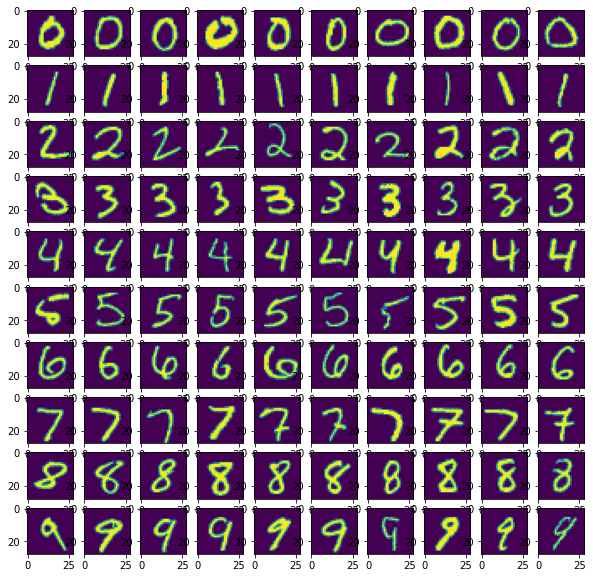

In [ ]:
index = []
for i in range(10):
  re = np.where(y_test == i)
  index.append(re[0][0:10])
index = np.array(index)
  
fig, ax = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
  for j in range(10):
    ax[i][j].imshow(x_test[index[i,j]], cmap='viridis')


### Predicted image

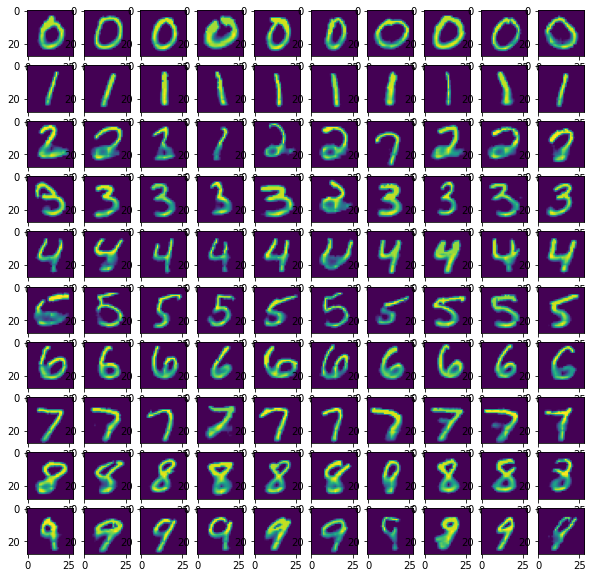

In [ ]:
fig, ax = plt.subplots(10,10,figsize=(10,10))
for i in range(10):
  for j in range(10):
    indi = index[i,j]
    new_img = image_creation(indi,test_arr_X)
    ax[i][j].imshow(new_img, cmap='viridis')

##Problem 2: Variational Autoencoders on Poor Sevens

1. tr7.pkl contains 6,265 MNIST digits from its training set, but not all ten digits. I only selected 7’s. Therefore, it’s with a rank-3 tensor of size 6, 265 × 28 × 28. Similarly, te7.pkl contains 1,028 7’s.

2. The digit images in this problem are special, because I added a special effect to them. So, they are different from the original 7’s in the MNIST dataset in a way. I want you to find out what I did to the poor 7’s.

3. Instead of eyeballing all those images, you need to implement a VAE that finds out a few latent dimensions, one of which should show you the effect I added.

4. Once again, I wouldn’t care too much about your network architecture. This could be a good chance for you to check out the performance of the CNN encoder, followed by a decoder with deconvolution layers (or transposed convolution layers), but do something else if you feel like. I found that fully-connected networks work just fine.

5. What’s important here in the VAE is, as a VAE, it needs a hidden layer that is dedicated to learn the latent embedding. In this layer, each hidden unit is governed by a standard normal distribution as its a priori information. Also, be careful about the re-parameterization technique and the loss function.

6. You’ll need to limit the number of hidden units K in your code layer (the embedding vector) with a small number (e.g. smaller than 5) to reduce your search space. Out of K, there must be a dimension that explains the effect that I added.

7. One way to prove that you found the latent dimension of interest is to show me the digits generated by the decoder. More specifically, you may want to “generate” new 7’s by feeding a few randomly generated code vectors, that are the random samples from the K normal distributions that your VAE learned. But, they won’t be enough to show which dimension takes care of my added effect. Therefore, your random code vectors should be formed specially.

8. What I’d do is to generate code vectors by fixing the K − 1 dimensions with the same value over the codes, while varying only one of them.

9. For example, if K = 3 and you’re interested in the third dimension, your codes should look like as follows:

Note that the first two column vectors are once randomly sampled from the normal distributions, but then shared by all the codes so that the variation found in the decoded output relies solely on the third dimension.

10. You’ll want to examine all the K dimensions by generating samples from each of them. Show me the ones you like. They should show a bunch of similar-looking 7’s but with gradually changing effect on them. The generated samples that show a gradual change of the thickness of the stroke, for example, are not a good answer, because that’s not the one I added, but something that was there in the dataset already.

11. Submit your notebook with figure and code.


#### Referenced from  https://keras.io/examples/generative/vae/

### Import the file

In [32]:
import pickle

with open('/content/drive/MyDrive/Deep Learning Assignment/hw5_tr7.pkl','rb') as file:
  tr_data=pickle.load(file)

with open('/content/drive/MyDrive/Deep Learning Assignment/hw5_te7.pkl','rb') as file:
  te_data=pickle.load(file)

In [33]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Conv2D,Input,Dense,Flatten
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.models import Sequential
from keras.initializers import HeNormal,GlorotNormal



#### Encoder Architechture

In [34]:
class vae_sampling(layers.Layer):
  def call(self, inputs):
    z_vae_mean, z_var_vae = inputs
    batch = tf.shape(z_vae_mean)[0]
    dim = tf.shape(z_vae_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_vae_mean + tf.exp(0.5 * z_var_vae) * epsilon

latent_dim = 3
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_vae_mean = layers.Dense(latent_dim, name="z_vae_mean")(x)
z_var_vae = layers.Dense(latent_dim, name="z_var_vae")(x)
z = vae_sampling()([z_vae_mean, z_var_vae])
encoder = keras.Model(encoder_inputs, [z_vae_mean, z_var_vae, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_8[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 4, 4, 128)    73856       ['conv2d_1[0][0]']               
                                                                                            

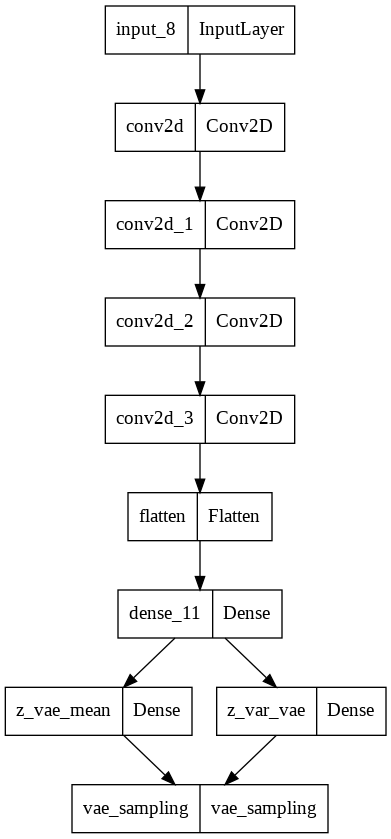

In [40]:
tf.keras.utils.plot_model(encoder)

#### Decoder Architecture

In [35]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_12 (Dense)            (None, 3136)              12544     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

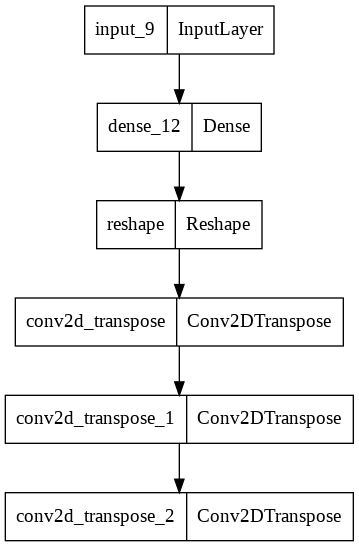

In [41]:
tf.keras.utils.plot_model(decoder)

### Variational Auto Encoder 

In [36]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_vae_mean, z_var_vae, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            kl_loss = 1 + z_var_vae - tf.square(z_vae_mean) - tf.exp(z_var_vae)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
             "kl_loss": kl_loss,
        }


tr_data=np.expand_dims(tr_data,axis=-1)
te_data=np.expand_dims(te_data,axis=-1)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())



In [37]:
history=vae.fit(tr_data, epochs=70, batch_size=16,shuffle=True)

Epoch 1/70
392/392 [==============================] - 9s 5ms/step - loss: 3437.3265 - reconstruction_loss: 3433.2099 - kl_loss: 4.1166
Epoch 2/70
392/392 [==============================] - 2s 5ms/step - loss: 2759.0775 - reconstruction_loss: 2750.3130 - kl_loss: 8.7645
Epoch 3/70
392/392 [==============================] - 2s 5ms/step - loss: 2650.7659 - reconstruction_loss: 2638.8563 - kl_loss: 11.9097
Epoch 4/70
392/392 [==============================] - 2s 5ms/step - loss: 2563.1519 - reconstruction_loss: 2550.4221 - kl_loss: 12.7298
Epoch 5/70
392/392 [==============================] - 2s 5ms/step - loss: 2493.3287 - reconstruction_loss: 2480.4328 - kl_loss: 12.8958
Epoch 6/70
392/392 [==============================] - 2s 5ms/step - loss: 2423.0598 - reconstruction_loss: 2410.5376 - kl_loss: 12.5222
Epoch 7/70
392/392 [==============================] - 2s 5ms/step - loss: 2373.9063 - reconstruction_loss: 2361.2286 - kl_loss: 12.6777
Epoch 8/70
392/392 [==============================

In [ ]:
encoder.save('/content/drive/MyDrive/Deep Learning Assignment/encoder_vae.h5')

In [ ]:
decoder.save('/content/drive/MyDrive/Deep Learning Assignment/decoder_vae.h5')

#### Predicting on test data

In [38]:
latent_repr=encoder.predict(te_data)
latent_sample=latent_repr[-1]
image=np.squeeze(decoder.predict(latent_sample))

#### Ploting the prediction

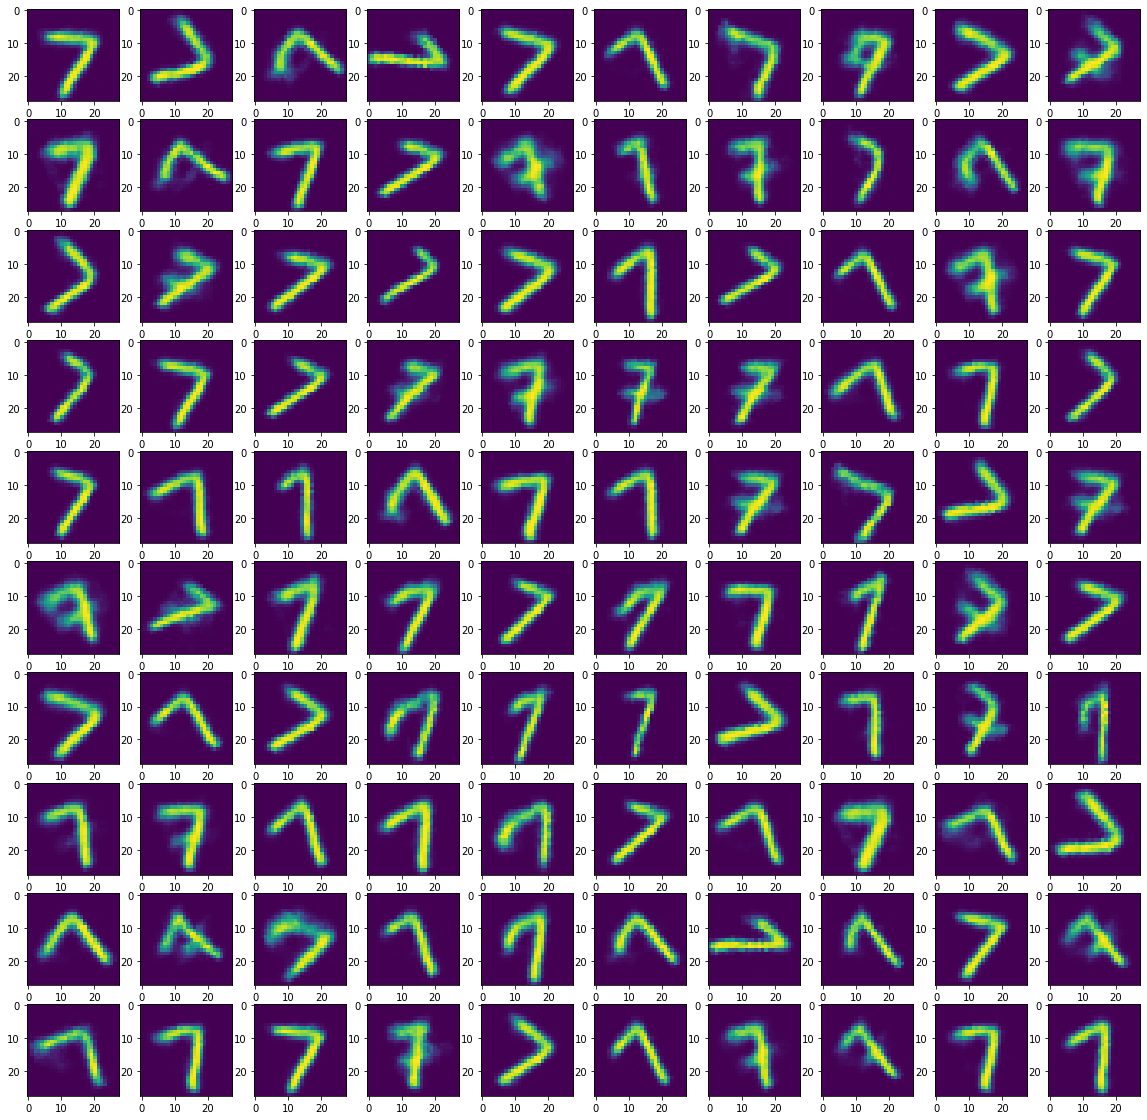

In [39]:
fig, axes=plt.subplots(nrows=10,ncols=10)
fig.set_figheight(20)
fig.set_figwidth(20)

for i in range(100):
  row=i//10
  column=i%10
  axes[row,column].imshow(image[i])

#### From the above image we can see that there are bunch of 7 which are rotated. So in the latent dimension rotation is added

## Problem 3: Conditional GAN

### Referenced from https://keras.io/examples/generative/conditional_gan/

1. Let’s develop a GAN model that can generate MNIST digits, but based on the auxiliary input from the user indicating which digit to create.

2. To this end, the generate has to be trained to receive two different kinds of input: the random vector and the class label.

3. The random vector is easy to create. It should be a d-dimensional vector, sampled from a standard normal distribution N (0, 1). d = 100 worked just fine for me.

4. As for the conditioning vector, you somehow need to inform the network of your intention. For example, if you want to generate a “0”, you need to give that information to the generator. There are many different ways to condition a neural network at various stages. But, this time, let’s use a simple one. We will convert the digit label into a one-hot vector. For example, if you want to generate a “7” the conditioning vector is [0, 0, 0, 0, 0, 0, 0, 1, 0, 0].

5. Then, we need to combine these two different kinds of information. Again, there are many different ways, but let’s just stick to a simple solution. We will concatenate the d-dimensional random vector and the 10-dimensional one-hot vector. Therefore, the input to your generator is with d + 10 dimensions. If your d = 100, the input dimension is 110.

6. You are free to choose whatever network architecture you want to practice with. Here’s the fully- connected one I found as a good starting point: 110 × 200 × 400 × 784. I used ReLU as the activation function, but as for the last layer, I used tanh. It means that I’ll interpret −1 as the black pixel while +1 being the white pixel.

7. The discriminator has a similar architecture: 794 × 400 × 200 × 100 × 1. The reason why it takes a 794-dim vector is that it wants to know what the image sample is conditioned on. Also note that it does binary classification to discern whether the conditioned input image is a real or fake example, i.e., you will need to set up the last layer as a logistic regression function.

8. To train this GAN model, sample a minibatch of B examples from your MNIST dataset. These are your real examples. But, instead of feeding them directly to your discriminator, you’ll append their label information by turning it into the one-hot representation. Don’t forget to match the scale: it has to be from −1 to +1 instead of [0, 1] as that’s how the generator defines the pixel intensity.

9. Accordingly, generate a class-balanced set of fake examples by feeding B random vectors to your generator. Again, each of your random vectors needs to be appended by a randomly chosen one- hot vector. For example, if your B = 100, you may want to generate ten ones, ten twos, and so on. Although the generated images are not with any label information anymore, you know that each should belong to a particular digit class based on your conditioning vector. Therefore, when you feed these fake examples to the discriminator, you need to append the one-hot vectors once again. Of course, the one-hot vectors should match the ones you used to inform the generator as input.

10. To summarize, the input to your generator is a d + 10-dim vector. The last 10 elements should be copied to augment your fake example, generated from the generator, to construct a 794-dim vector. You have B fake examples as such. The real examples are with the same size, but their first 784 elements are from the real MNIST images, accompanied by the last 10 elements representing the class, to which the image belongs.

11. Train this GAN model. I used Adam with lower-than-usual learning rates. Dropout helped the discriminator. Below is the figure that shows the change of the classification accuracy over the epochs (red for real and blue for fake examples). I can see that it converged to the Nash equilibrium, as the discriminator seems to be confused.

12. Below is the test examples that I generated by feeding new random vectors (plus the intended class labels). I placed ten examples per class in a row. These are of course not the best MNIST digits I can imagine, but they look fine given the simple structure and algorithm I used.

13. Please feel free to use whatever other things you want to try out, such as WGAN, but if your results are decent (like mine) we’ll give away the full score.

14. Report both the convergence graph as well as the generated examples.


In [1]:
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import time
import os
from PIL import Image
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import tensorflow as tf

#### Load the data

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
# Preprocessing
def preprocess(x,y):
  # reshape the data
  x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
  # labels encoding
  encoder=OneHotEncoder()
  encoder.fit(y)
  y = encoder.transform(y).toarray()
  x,y=shuffle(x,y)
  # Scaling
  scaler=MinMaxScaler(feature_range=(-1,1))
  x=scaler.fit_transform(x)
  return x,y

x_train,y_train =preprocess(x_train,y_train.reshape(-1,1))
x_test,y_test =preprocess(x_test,y_test.reshape(-1,1))

#### Discriminator Architecture

In [4]:
noise_dim=100
no_class=10

def build_gan_discriminator():
  model=Sequential()
  discri_input_img=Input(shape=(784,))
  discri_input_label=Input(shape=(no_class,))
  model_input=Concatenate(axis=1)([discri_input_img,discri_input_label])
  
  model.add(Dense(units=400,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))

  model.add(Dense(units=200,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))

  model.add(Dense(units=100,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.1))

  model.add(Dense(units=1,activation='sigmoid',kernel_initializer='GlorotNormal'))
  
  dis_pred=model(model_input)

  return Model([discri_input_img,discri_input_label],dis_pred,name='gan_discriminator')

gan_discriminator = build_gan_discriminator()
gan_discriminator.summary()

Model: "gan_discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 794)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 sequential (Sequential)        (None, 1)            418401      ['concatenate[0][

In [5]:
gan_discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0002, 0.5), metrics = ['binary_accuracy'])

#### Generator Architechture

In [6]:
noise=Input(shape=(noise_dim,))
auxi_input=Input(shape=(no_class,))

def build_gan_generator():
  model=Sequential()
  model_input=Concatenate(axis=1)([noise,auxi_input])

  model.add(Dense(units=200,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  
  model.add(Dense(units=400,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(units=784,activation='tanh',kernel_initializer='HeNormal'))
  generate_img=model(model_input)
  return Model([noise,auxi_input],generate_img,name='gan_generator')

gan_generator = build_gan_generator()
gan_generator.summary()

gan_discriminator.trainable = False
img = gan_generator([noise,auxi_input])
prediction = gan_discriminator([img, auxi_input])
CGAN_model = Model([noise, auxi_input], prediction)
CGAN_model.compile(loss= 'binary_crossentropy', optimizer = Adam(0.0002,0.5))

Model: "gan_generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 110)          0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 784)          419384      ['concatenate_1[0][0]

In [73]:
CGAN_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 gan_generator (Functional)     (None, 784)          419384      ['input_22[0][0]',               
                                                                  'input_23[0][0]']               
                                                                                                  
 gan_discriminator (Functional)  (None, 1)           418401      ['gan_generator[0][0]',    

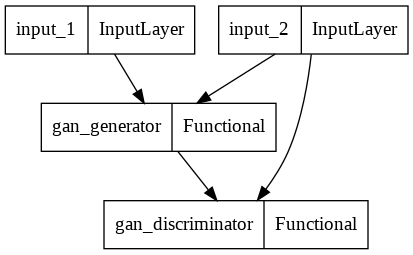

In [ ]:
tf.keras.utils.plot_model(CGAN_model)

#### Store the image

In [7]:
import os
if 'gans' not in os.listdir():
    os.mkdir('gans')

def store_image(epoch):
  r, c = 2,5
  z = np.random.normal(0,1,(r*c, noise_dim))
  labels = np.eye(no_class)
  generated_pic = gan_generator.predict([z,labels])
  generated_pic = 0.5 * generated_pic + 0.5
    
  fig, axes = plt.subplots(r,c, figsize = (10,10))
  count = 0
  for i in range(r):
    for j in range(c):
      axes[i,j].imshow(generated_pic[count,:].reshape((28,28)),cmap = 'gray')
      axes[i,j].axis('off')
      axes[i,j].set_title("Digit: %d" % np.argmax(labels[count,:]))
      count+=1
  plt.savefig(f'gans/cgan_{epoch}.jpg')
  plt.close()

#### Training the GANS

In [8]:
def gans_training(epochs, batch_size, store_condition):
  real = np.ones(shape= (batch_size, 1))
  fake = np.zeros(shape = (batch_size,1))
  
  real_accs=[]
  fake_accs=[]

  gen_losses=[]
  discrim_losses=[]
  for epoch in range(epochs):    
    for i in range(0,len(x_train),batch_size):
      
      gan_discriminator.trainable = True
      
      img, labels = x_train[i:i+batch_size,:], y_train[i:i+batch_size,:]
      dis_loss_real_batch,dis_accuracy_real_batch = gan_discriminator.train_on_batch([img, labels], real[:len(labels),:])

      z = np.random.normal(0,1,size = (batch_size, noise_dim))
      
      fake_labels = np.eye(no_class)[np.random.choice(no_class, batch_size,replace=True)]
      generate_img = gan_generator.predict([z,fake_labels])
      dis_loss_fake_batch,dis_accuracy_fake_batch = gan_discriminator.train_on_batch([generate_img, fake_labels], fake[:len(fake_labels),:])

      discrim_loss=(dis_loss_real_batch+dis_loss_fake_batch)/2

      gan_discriminator.trainable = False
      z = np.random.normal(0,1,size = (batch_size, noise_dim))
      labels = np.eye(no_class)[np.random.choice(no_class, batch_size,replace=True)]
      g_loss = CGAN_model.train_on_batch([z,labels], real)
    
    
    epoch_real_accuracy=dis_accuracy_real_batch
    epoch_fake_accuracy=dis_accuracy_fake_batch
    epoch_gen_loss=g_loss
    epoch_discrim_losses=discrim_loss
    print(f"Epoch: {epoch} Discriminator Loss: {epoch_discrim_losses} Accuracy Real Image: {epoch_real_accuracy} Accuracy Fake Image: {epoch_fake_accuracy} Generator Loss- {epoch_gen_loss}")

    real_accs.append(epoch_real_accuracy)
    fake_accs.append(epoch_fake_accuracy)
    gen_losses.append(epoch_gen_loss)
    discrim_losses.append(epoch_discrim_losses)

    if epoch % store_condition == 0:
      store_image(epoch)
  
  return (real_accs,fake_accs,gen_losses,discrim_losses)

In [9]:
history=gans_training(50, 128, 10)

Epoch: 0 Discriminator Loss: 0.259649358689785 Accuracy Real Image: 0.9270833134651184 Accuracy Fake Image: 0.859375 Generator Loss- 6.060632705688477
Epoch: 1 Discriminator Loss: 0.5802095532417297 Accuracy Real Image: 0.6979166865348816 Accuracy Fake Image: 0.6875 Generator Loss- 1.1675922870635986
Epoch: 2 Discriminator Loss: 0.5603232085704803 Accuracy Real Image: 0.6979166865348816 Accuracy Fake Image: 0.734375 Generator Loss- 1.1629588603973389
Epoch: 3 Discriminator Loss: 0.47063226997852325 Accuracy Real Image: 0.7708333134651184 Accuracy Fake Image: 0.78125 Generator Loss- 1.3968775272369385
Epoch: 4 Discriminator Loss: 0.40914490818977356 Accuracy Real Image: 0.7708333134651184 Accuracy Fake Image: 0.875 Generator Loss- 1.552762746810913
Epoch: 5 Discriminator Loss: 0.49151934683322906 Accuracy Real Image: 0.75 Accuracy Fake Image: 0.8046875 Generator Loss- 1.7166911363601685
Epoch: 6 Discriminator Loss: 0.3619787395000458 Accuracy Real Image: 0.8125 Accuracy Fake Image: 0.84

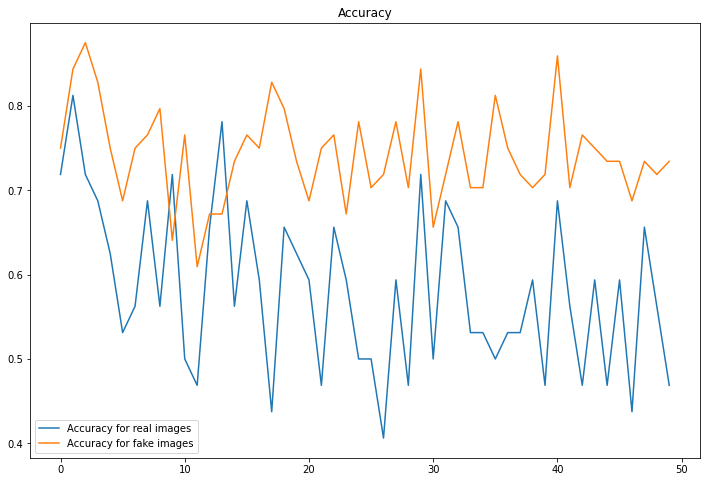

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history[0],label='Accuracy for real images');
plt.plot(history[1],label='Accuracy for fake images');
plt.title("Accuracy")
plt.legend();

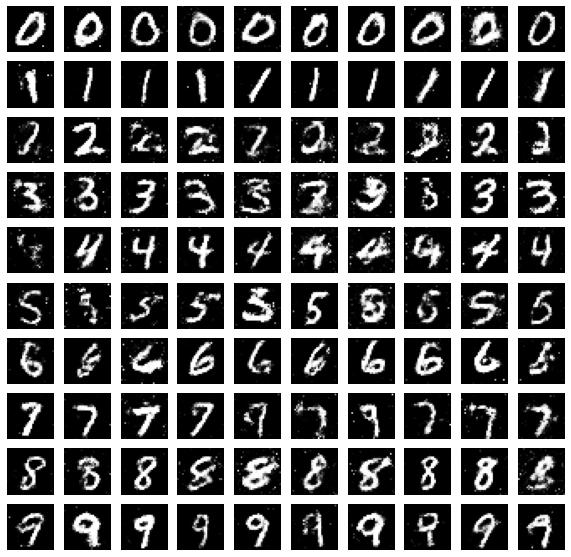

In [ ]:
r, c = 10,10
z = np.random.normal(0,1,(r*c, noise_dim))


labels=[]
for vector in np.eye(no_class):
  for _ in range(10):
    labels.append(vector.tolist())

labels=np.array(labels)

generated_pic = gan_generator.predict([z,labels])
generated_pic = 0.5 * generated_pic + 0.5
    
fig, axes = plt.subplots(r,c, figsize = (10,10))
count = 0
for i in range(r):
  for j in range(c):
    axes[i,j].imshow(generated_pic[count,:].reshape((28,28)),cmap = 'gray')
    axes[i,j].axis('off')
    count+=1

## Problem 4: Missing Value Imputation Using Conditional GAN

1. We’ve already seen that LSTM can act like generative model that can “predict future patches” given the “past patches” in P1.

2. This time, we’ll do something similar but by using GAN. This time, it works like a missing value imputation system. We assume that only the center part of the image is known, while the generator has to predict what the other surrounding pixels are.

3. We’ll formulate this as a conditional GAN. First, take a batch of MNIST images. Take their center 10 × 10 patches, and then flatten it. This is your 100-dimensional conditioning vector. Since there are 28 × 28 pixels in each image, you’ll do something like this, X[:,10:19,10:19], to take the center patch. This will form a B × 100 matrix, for your batch of B conditioning vectors.

4. Append this matrix to your random vectors of 100 dimensions drawn from the standard normal dis- tribution. This B × 200 matrix is the input to your generator.

5. The generator takes this 200 dimensional vectors and synthesizes MNIST-looking digits. You will need to prepare another set of B real examples. Eventually, you feed 2B examples in total to your discriminator as a minibatch.

6. If both discriminator and generator are trained properly, you can see that the results are some MNIST- looking digits. But, I found that the generator simply ignores the conditioning vector and generate whatever it wants to generate. They all certainly look like MNIST digits, but the conditioning part doesn’t work. Below is the generated images (left) and the ground-truth images that I extracted the center patches from (right).

7. So, even though I did feed the center patch as the conditioning vector to the generator, it ignores it and generate something totally different. It’s because, I think, the generator has no way to know the conditioning vector is actually the center patch of the digit that it must generate. In other words, the generator is generating the whole image, although it doesn’t have to generate the center patch, which is known to me. Instead, I wanted it to generate the surrounding pixels, that are the missing values.

8. As a remedy, I added another regularizer to my generator so that it functions as an autoencoder at least for the center pixels. You know, in an ordinary GAN setup, the generator loss has to penalize the discriminator’s decision that classifies the fake examples into the fake class (i.e., when the generator fails to fool the discriminator). On top of this ordinary generator loss, I add a simple mean squared error term that penalizes the difference between the conditioning vector and the center patch of the generated image, as they have to be the same, essentially.

9. Since it’s a regularizer, I needed to investigate different λ values to control its contribution to the total loss of the generator. It turned out that the generator is not too sensitive to this choice, although it does generate a “less conditioned” example when it comes to a too small λ. Below is the two sets of examples when I set λ = 0.1 (left) and λ = 10 (right).

10. Replicate what I did with the regularized model and submit your code and generated examples (i.e., you don’t have to replicate my failed model with no regularization). Once again, you can try some other fancy models and different ways to condition the model. But we’ll give you a full score if your results are as good as mine.

### Load and preprocess the data

In [42]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

def preprocess(x,y):
  # reshape the data
  x = x.reshape(x.shape[0], x.shape[1]*x.shape[2])
  # labels encoding
  encoder=OneHotEncoder()
  encoder.fit(y)
  y = encoder.transform(y).toarray()

  x,y=shuffle(x,y)
  # Scaling
  scaler=MinMaxScaler(feature_range=(-1,1))
  x=scaler.fit_transform(x)
  return x,y

x_train,y_train =preprocess(x_train,y_train.reshape(-1,1))
x_test,y_test =preprocess(x_test,y_test.reshape(-1,1))

In [43]:
noise_dim=100
no_class=10

def build_gan_discriminator():
  model=Sequential()
  discri_input_img=Input(shape=(784,))
  discri_input_label=Input(shape=(no_class,))
  model_input=Concatenate(axis=1)([discri_input_img,discri_input_label])
  
  model.add(Dense(units=400,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))

  model.add(Dense(units=200,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.2))

  model.add(Dense(units=100,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.1))

  model.add(Dense(units=1,activation='sigmoid',kernel_initializer='GlorotNormal'))
  
  dis_pred=model(model_input)

  return Model([discri_input_img,discri_input_label],dis_pred,name='gan_discriminator')

gan_discriminator = build_gan_discriminator()
gan_discriminator.summary()

Model: "gan_discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 784)]        0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 794)          0           ['input_10[0][0]',               
                                                                  'input_11[0][0]']               
                                                                                                  
 sequential_4 (Sequential)      (None, 1)            418401      ['concatenate_3[0

In [44]:
gan_discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0002, 0.5), metrics = ['binary_accuracy'])

In [45]:

noise=Input(shape=(noise_dim,))
auxi_input=Input(shape=(no_class,))

def build_gan_generator():
  model=Sequential()
  model_input=Concatenate(axis=1)([noise,auxi_input])

  model.add(Dense(units=200,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  
  model.add(Dense(units=400,kernel_initializer='HeNormal'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))

  model.add(Dense(units=784,activation='tanh',kernel_initializer='HeNormal'))
  generate_img=model(model_input)
  return Model([noise,auxi_input],generate_img,name='gan_generator')

gan_generator = build_gan_generator()
gan_generator.summary()

Model: "gan_generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 concatenate_4 (Concatenate)    (None, 110)          0           ['input_12[0][0]',               
                                                                  'input_13[0][0]']               
                                                                                                  
 sequential_5 (Sequential)      (None, 784)          419384      ['concatenate_4[0][0]

In [46]:
gan_discriminator.trainable = False
img = gan_generator([noise,auxi_input])
prediction = gan_discriminator([img, auxi_input])
CGAN_model = Model([noise, auxi_input], prediction)
CGAN_model.compile(loss= 'binary_crossentropy', optimizer = Adam(0.0002,0.5))

In [47]:
def extract_center(X):
    X = X.reshape([-1,28,28])
    return X[:,9:19,9:19].reshape(-1,100)

In [48]:
import os
if 'gans' not in os.listdir():
    os.mkdir('gans')

def store_image(epoch):
  r, c = 2,5
  z = np.random.normal(0,1,(r*c, noise_dim))
  labels = np.eye(no_class)
  generated_pic = gan_generator.predict([z,labels])
  generated_pic = 0.5 * generated_pic + 0.5
    
  fig, axes = plt.subplots(r,c, figsize = (10,10))
  count = 0
  for i in range(r):
    for j in range(c):
      axes[i,j].imshow(generated_pic[count,:].reshape((28,28)),cmap = 'gray')
      axes[i,j].axis('off')
      axes[i,j].set_title("Digit: %d" % np.argmax(labels[count,:]))
      count+=1
  plt.savefig(f'gans/cgan_{epoch}.jpg')
  plt.close()

In [49]:
def gans_training(epochs, batch_size, store_condition):
  real = np.ones(shape= (batch_size, 1))
  fake = np.zeros(shape = (batch_size,1))
  
  real_accs=[]
  fake_accs=[]

  gen_losses=[]
  discrim_losses=[]
  for epoch in range(epochs):    
    for i in range(0,len(x_train)-batch_size,batch_size):
      
      gan_discriminator.trainable = True
      
      img, labels = x_train[i:i+batch_size,:], y_train[i:i+batch_size,:]
      dis_loss_real_batch,dis_accuracy_real_batch = gan_discriminator.train_on_batch([img, labels], real[:len(labels),:])

      #z = np.random.normal(0,1,size = (batch_size, noise_dim))
      z = extract_center(img)

      
      fake_labels = np.eye(no_class)[np.random.choice(no_class, batch_size,replace=True)]
      generate_img = gan_generator.predict([z,fake_labels])
      dis_loss_fake_batch,dis_accuracy_fake_batch = gan_discriminator.train_on_batch([generate_img, fake_labels], fake[:len(fake_labels),:])

      discrim_loss=(dis_loss_real_batch+dis_loss_fake_batch)/2

      gan_discriminator.trainable = False
      z = np.random.normal(0,1,size = (batch_size, noise_dim))
      labels = np.eye(no_class)[np.random.choice(no_class, batch_size,replace=True)]
      g_loss = CGAN_model.train_on_batch([z,labels], real) + (
                penalty_lambda * np.mean(np.square(extract_center(generate_img) - z)))
    
    
    epoch_real_accuracy=dis_accuracy_real_batch
    epoch_fake_accuracy=dis_accuracy_fake_batch
    epoch_gen_loss=g_loss
    epoch_discrim_losses=discrim_loss
    print(f"Epoch: {epoch} Loss from Discriminator: {epoch_discrim_losses} Real Img Accuracy: {epoch_real_accuracy}  Fake Img Accuracy: {epoch_fake_accuracy} Loss for Generator - {epoch_gen_loss}")

    real_accs.append(epoch_real_accuracy)
    fake_accs.append(epoch_fake_accuracy)
    gen_losses.append(epoch_gen_loss)
    discrim_losses.append(epoch_discrim_losses)

    if epoch % store_condition == 0:
      store_image(epoch)
  
  return (real_accs,fake_accs,gen_losses,discrim_losses)



#### Penalty = 0.1

In [50]:
penalty_lambda = 0.1
history=gans_training(50, 128, 10)


Epoch: 0 Loss from Discriminator: 0.007369957398623228 Real Img Accuracy: 1.0  Fake Img Accuracy: 0.99609375 Loss for Generator - 6.877151184759376
Epoch: 1 Loss from Discriminator: 0.4735100567340851 Real Img Accuracy: 0.84765625  Fake Img Accuracy: 0.6953125 Loss for Generator - 3.360127286729179
Epoch: 2 Loss from Discriminator: 0.3633885979652405 Real Img Accuracy: 0.875  Fake Img Accuracy: 0.8515625 Loss for Generator - 1.3415606043026627
Epoch: 3 Loss from Discriminator: 0.47522421181201935 Real Img Accuracy: 0.78125  Fake Img Accuracy: 0.79296875 Loss for Generator - 1.0568982927506767
Epoch: 4 Loss from Discriminator: 0.4199919104576111 Real Img Accuracy: 0.80859375  Fake Img Accuracy: 0.7734375 Loss for Generator - 1.197045345155144
Epoch: 5 Loss from Discriminator: 0.3692246973514557 Real Img Accuracy: 0.80078125  Fake Img Accuracy: 0.83984375 Loss for Generator - 1.2903460557737556
Epoch: 6 Loss from Discriminator: 0.3447267562150955 Real Img Accuracy: 0.8359375  Fake Img Ac

In [52]:
def patches_label(train_x,train_y,label):
    train_y = np.argmax(train_y,axis=1)
    indices_all = [i for i in range(len(train_y)) if train_y[i]==label]
    indices = np.random.choice(indices_all,size=10)
    return train_x[indices].reshape([-1,28,28])[:,9:19,9:19].reshape([-1,100])

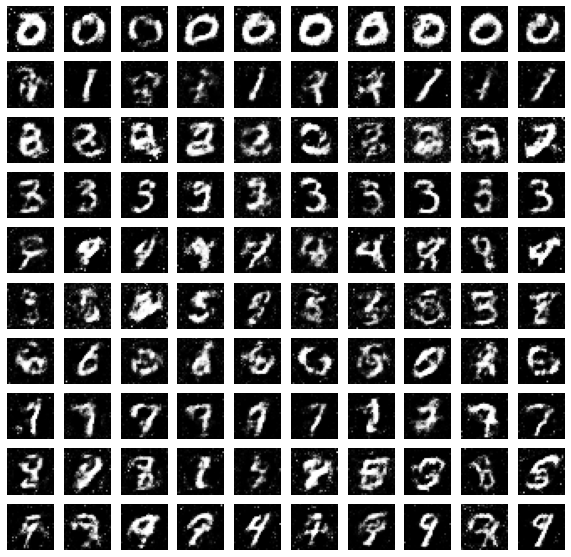

In [20]:
r, c = 10,10
#z = np.random.normal(0,1,(r*c, noise_dim))
z = [patches_label(x_train,y_train,label) for label in range(10)]
z = np.concatenate(z)


labels=[]
for vector in np.eye(no_class):
  for _ in range(10):
    labels.append(vector.tolist())

labels=np.array(labels)

generated_pic = gan_generator.predict([z,labels])

generated_pic = 0.5 * generated_pic + 0.5
    
fig, axes = plt.subplots(r,c, figsize = (10,10))
count = 0
for i in range(r):
  for j in range(c):
    axes[i,j].imshow(generated_pic[count,:].reshape((28,28)),cmap = 'gray')
    axes[i,j].axis('off')
    count+=1

#### Penalty = 10

In [27]:
penalty_lambda = 10
history=gans_training(50, 128, 10)

Epoch: 0 Loss from Discriminator: 0.3005833178758621 Real Img Accuracy: 0.8203125  Fake Img Accuracy: 0.875 Loss for Generator - 18.296454538861866
Epoch: 1 Loss from Discriminator: 0.36081473529338837 Real Img Accuracy: 0.8125  Fake Img Accuracy: 0.8203125 Loss for Generator - 18.18813519431116
Epoch: 2 Loss from Discriminator: 0.2887621223926544 Real Img Accuracy: 0.8515625  Fake Img Accuracy: 0.8828125 Loss for Generator - 18.128236743207207
Epoch: 3 Loss from Discriminator: 0.2623089700937271 Real Img Accuracy: 0.8984375  Fake Img Accuracy: 0.9140625 Loss for Generator - 18.19744277669274
Epoch: 4 Loss from Discriminator: 0.32891231775283813 Real Img Accuracy: 0.8359375  Fake Img Accuracy: 0.84375 Loss for Generator - 18.396649512860094
Epoch: 5 Loss from Discriminator: 0.22694805264472961 Real Img Accuracy: 0.8984375  Fake Img Accuracy: 0.96875 Loss for Generator - 18.42232924606835
Epoch: 6 Loss from Discriminator: 0.3164421319961548 Real Img Accuracy: 0.828125  Fake Img Accuracy

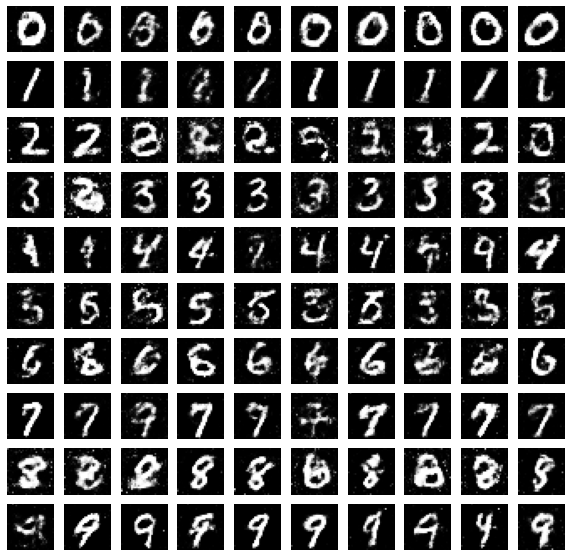

In [28]:
r, c = 10,10

z = [patches_label(x_train,y_train,label) for label in range(10)]
z = np.concatenate(z)


labels=[]
for vector in np.eye(no_class):
  for _ in range(10):
    labels.append(vector.tolist())

labels=np.array(labels)

generated_pic = gan_generator.predict([z,labels])
generated_pic = 0.5 * generated_pic + 0.5
    
fig, axes = plt.subplots(r,c, figsize = (10,10))
count = 0
for i in range(r):
  for j in range(c):
    axes[i,j].imshow(generated_pic[count,:].reshape((28,28)),cmap = 'gray')
    axes[i,j].axis('off')
    count+=1